[View in Colaboratory](https://colab.research.google.com/github/Sirius79/NALU/blob/master/NALU.ipynb)

In [0]:
!pip install torchvision
!pip install torchtext

In [0]:
import torch
import torch.nn as nn
import  torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.nn.parameter import Parameter
import torch.nn.init as init
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
class NACCell(nn.Module):
  '''
    Neural Accumulator Cell
  '''
  def __init__(self, input_size, output_size):
    '''
      input_size: input dimension
      output_size: output dimension
    '''
    super(NACCell, self).__init__()
    self.input = input_size
    self.output = output_size
    
    self.W_h = Parameter(torch.Tensor(self.output, self.input, device=device))
    self.M_h = Parameter(torch.Tensor(self.output, self.input, device=device))
    self.W = Parameter(torch.tanh(self.W_h) * torch.sigmoid(self.M_h))
    self.register_parameter('bias', None)
    
    init.xavier_uniform_(self.W_h)
    init.xavier_uniform_(self.M_h)
  
  def forward(self, input):
    return F.linear(input, self.W, self.bias)

In [0]:
class NAC(nn.Module):
  '''
    stack Neural Accumulator Cells
  '''
  def __init__(self, input_size, hidden_size, output_size, num_layers):
    '''
      input_size: input dim
      hidden_size: hidden dim
      output_size: output dim
      num_layers: number of layers
    '''
    super(NAC, self).__init__()
    self.input = input_size
    self.hidden = hidden_size
    self.output = output_size
    self.num_layers = num_layers
    
    layers = [NACCell(self.hidden if i>0 else self.input, self.hidden if i<num_layers-1 else self.output) for i in range(num_layers)]
    self.model = nn.Sequential(*layers)
  
  def forward(self, input):
    return self.model(input)

In [0]:
class NeuralALUCell(nn.Module):
  '''
    Neural Arithmetic Logic Unit Cell 
  '''
  def __init__(self, input_size, output_size, epsilon = 1e-5):
    '''
      input_size: input dimension
      output_size: output dimension
      epsilon: prevents log0
    '''
    super(NeuralALUCell, self).__init__()
    self.input = input_size
    self.output = output_size
    self.epsilon = epsilon
    
    self.G = Parameter(torch.Tensor(self.output, self.input, device=device))
    self.W = Parameter(torch.Tensor(self.output, self.input, device=device))
    self.register_parameter('bias', None)
    self.nac = NACCell(self.input, self.output)
    
    init.xavier_uniform_(self.G)
    init.xavier_uniform_(self.W)
  
  def forward(self, input):
    '''
      g*a: addition-subtraction
      (1-g)*m: multiplication-division
    '''
    a = self.nac(input)
    g = torch.sigmoid(F.linear(input, self.G, self.bias))
    m = torch.exp(F.linear(torch.log(torch.abs(input) + self.epsilon), self.W, self.bias))
    return g*a + (1-g)*m

In [0]:
class NALU(nn.Module):
  '''
    stacked NALU Cells
  '''
  def __init__(self, input_size, hidden_size, output_size, num_layers, epsilon = 1e-5):
    '''
      input_size: input dim
      hidden_size: hidden dim
      output_size: output dim
      num_layers: number of layers
      epsilon: prevents log0
    '''
    super(NALU, self).__init__()
    self.input = input_size
    self.hidden = hidden_size
    self.output = output_size
    self.num_layers = num_layers
    self.epsilon = epsilon
    
    layers = [NeuralALUCell(self.hidden if i>0 else self.input, self.hidden if i<num_layers-1 else self.output, self.epsilon) for i in range(num_layers)]
    self.model = nn.Sequential(*layers)
  
  def forward(self, input):
    return self.model(input)

## Simple Learning Functions

In [88]:
fn = lambda x, y: x * y
x = torch.rand(2)*10
y = torch.tensor([fn(*x)])
print(x, y)

tensor([3.1639, 6.5570]) tensor([20.7458])


In [0]:
def generate(train_size, test_size, fn):
  X, Y = torch.Tensor(train_size + test_size, 2, device=device), torch.Tensor(train_size + test_size, 1, device=device)
  for i in range(train_size + test_size):
    x = torch.rand(2, device=device)*10
    y = torch.tensor([fn(*x)], device=device)
    X[i] = x
    Y[i] = y
  X_train, y_train = X[:train_size], Y[:train_size]
  X_test, y_test = X[train_size:], Y[train_size:]
  return X_train, y_train, X_test, y_test

In [0]:
fn = lambda x, y: x % y
#X, Y = generate(500, 50, fn)
X_tr, y_tr, X_t, y_t = generate(500, 50, fn)

In [8]:
print(X_tr[0],y_tr[0])

tensor([8.3774, 3.9029]) tensor([0.5716])


In [0]:
def train(model, optimizer, data, target, num_iters):
  all_losses = []
  for i in range(num_iters):
    out = model(data)
    loss = F.mse_loss(out, target)
    all_losses.append(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
      print("\t{}/{}: loss: {:.7f} ".format(i+1, num_iters, loss.item()))
  return all_losses

In [11]:
net = NALU(2,2,1,2)
optim = torch.optim.RMSprop(net.parameters(), lr=1e-3)
all_losses = train(net, optim, X_tr, y_tr, 100000)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


	1/100000: loss: 4.2592731 
	1001/100000: loss: 1.6628846 
	2001/100000: loss: 1.5179950 
	3001/100000: loss: 1.2823309 
	4001/100000: loss: 1.0541124 
	5001/100000: loss: 0.8825064 
	6001/100000: loss: 0.7961071 
	7001/100000: loss: 0.7179233 
	8001/100000: loss: 0.6254018 
	9001/100000: loss: 0.5399483 
	10001/100000: loss: 0.4865454 
	11001/100000: loss: 0.4586742 
	12001/100000: loss: 0.4483366 
	13001/100000: loss: 0.4436103 
	14001/100000: loss: 0.4298256 
	15001/100000: loss: 0.4180274 
	16001/100000: loss: 0.4078645 
	17001/100000: loss: 0.3987384 
	18001/100000: loss: 0.3903132 
	19001/100000: loss: 0.3822236 
	20001/100000: loss: 0.3746312 
	21001/100000: loss: 0.3678826 
	22001/100000: loss: 0.3617265 
	23001/100000: loss: 0.3560369 
	24001/100000: loss: 0.3507447 
	25001/100000: loss: 0.3458109 
	26001/100000: loss: 0.3412099 
	27001/100000: loss: 0.3369379 
	28001/100000: loss: 0.3330427 
	29001/100000: loss: 0.3295566 
	30001/100000: loss: 0.3260975 
	31001/100000: loss: 

	78001/100000: loss: 0.2562526 
	79001/100000: loss: 0.2555827 
	80001/100000: loss: 0.2549240 
	81001/100000: loss: 0.2542750 
	82001/100000: loss: 0.2536360 
	83001/100000: loss: 0.2530054 
	84001/100000: loss: 0.2523832 
	85001/100000: loss: 0.2517692 
	86001/100000: loss: 0.2511643 
	87001/100000: loss: 0.2505638 
	88001/100000: loss: 0.2499743 
	89001/100000: loss: 0.2493915 
	90001/100000: loss: 0.2488150 
	91001/100000: loss: 0.2482455 
	92001/100000: loss: 0.2476819 
	93001/100000: loss: 0.2471237 
	94001/100000: loss: 0.2465719 
	95001/100000: loss: 0.2460266 
	96001/100000: loss: 0.2454842 
	97001/100000: loss: 0.2449513 
	98001/100000: loss: 0.2444225 
	99001/100000: loss: 0.2439007 


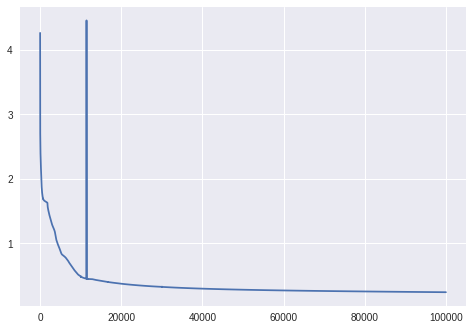

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [0]:
def test(model, data, target):
  with torch.no_grad():
    out = model(data)
    return out

In [14]:
res = []
mse = test(net, X_t, y_t)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [15]:
print(X_t[1], y_t[1], mse[1])

tensor([8.5945, 9.5916]) tensor([8.5945]) tensor([8.7337])


## MNIST recognition

In [0]:
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 32
num_epochs = 100
learning_rate = 0.001

In [8]:
train_dataset = torchvision.datasets.MNIST(root='../../data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='../../data/', train=False, transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Processing...
Done!


In [0]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes, linear=True):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    if linear:
      self.out = nn.Linear(hidden_size, num_classes)
    else:
      self.out = NALU(128, 100, num_classes, 2)
    
  def forward(self, input): 
    # Set initial hidden and cell states 
    hidden = torch.zeros(self.num_layers, input.size(0), self.hidden_size).to(device) 
    cell_state = torch.zeros(self.num_layers, input.size(0), self.hidden_size).to(device)
    # Forward propagate LSTM
    output, _ = self.lstm(input, (hidden, cell_state))  # out: tensor of shape (batch_size, seq_length, hidden_size)
    # Decode the hidden state of the last time step
    output = self.out(output[:, -1, :])
    return output

In [0]:
model = RNN(input_size, hidden_size, num_layers, num_classes, False).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
# Train the model
def train(model, optimizer, train_loader, criterion, num_epochs):
  all_losses = []
  total_step = len(train_loader)
  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
      images = images.reshape(-1, sequence_length, input_size).to(device)
      labels = labels.to(device)
        
      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)
      all_losses.append(loss)
      
      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
        
      if (i+1) % 100 == 0:
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
  return all_losses

In [32]:
all_losses = train(model, optimizer, train_loader, criterion, num_epochs)

Epoch [1/100], Step [100/1875], Loss: 9.9565
Epoch [1/100], Step [200/1875], Loss: 3.7254
Epoch [1/100], Step [300/1875], Loss: 3.0221
Epoch [1/100], Step [400/1875], Loss: 3.2592
Epoch [1/100], Step [500/1875], Loss: 2.0817
Epoch [1/100], Step [600/1875], Loss: 2.2614
Epoch [1/100], Step [700/1875], Loss: 2.3010
Epoch [1/100], Step [800/1875], Loss: 2.3388
Epoch [1/100], Step [900/1875], Loss: 2.0606
Epoch [1/100], Step [1000/1875], Loss: 2.2694
Epoch [1/100], Step [1100/1875], Loss: 2.1438
Epoch [1/100], Step [1200/1875], Loss: 2.7314
Epoch [1/100], Step [1300/1875], Loss: 2.0363
Epoch [1/100], Step [1400/1875], Loss: 2.0855
Epoch [1/100], Step [1500/1875], Loss: 2.0446
Epoch [1/100], Step [1600/1875], Loss: 2.1368
Epoch [1/100], Step [1700/1875], Loss: 2.1489
Epoch [1/100], Step [1800/1875], Loss: 2.1537
Epoch [2/100], Step [100/1875], Loss: 1.8390
Epoch [2/100], Step [200/1875], Loss: 2.1190
Epoch [2/100], Step [300/1875], Loss: 2.0269
Epoch [2/100], Step [400/1875], Loss: 2.1444
E

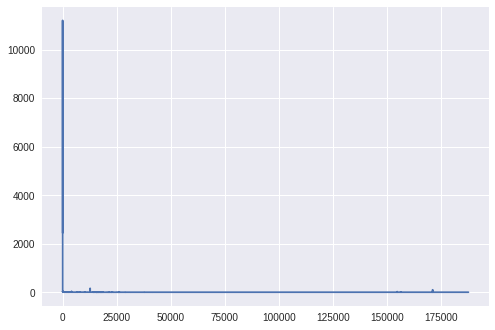

In [33]:
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [0]:
def test(model, test_loader):
  # Test the model
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
      images = images.reshape(-1, sequence_length, input_size).to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 


In [34]:
test(model, test_loader)

Test Accuracy of the model on the 10000 test images: 99.03 %


In [36]:
with torch.no_grad():
  for images, labels in test_loader:
    images = images.reshape(-1, sequence_length, input_size).to(device)
    labels = labels.to(device)
    print(labels)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    print(predicted)
    break

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1], device='cuda:0')
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1], device='cuda:0')
